# Example of multi-variable Linear Regression

<img src="./images/wines.jpeg" style="float:center" />

In this notebook we use the following [dataset](https://archive.ics.uci.edu/ml/datasets/wine+quality) from the [UCI machine learning repository](https://archive.ics.uci.edu/ml/index.php) which contains a lot of usefull dataset for training purposes.

Here, we will try to predict the quality of the wine using the available features.

### Data Set Information

The two datasets are related to red and white variants of the Portuguese "Vinho Verde" wine. For more details, consult: [Web Link] or the reference [Cortez et al., 2009]. Due to privacy and logistic issues, only physicochemical (inputs) and sensory (the output) variables are available (e.g. there is no data about grape types, wine brand, wine selling price, etc.).

These datasets can be viewed as classification or regression tasks. The classes are ordered and not balanced (e.g. there are many more normal wines than excellent or poor ones). Outlier detection algorithms could be used to detect the few excellent or poor wines. Also, we are not sure if all input variables are relevant. So it could be interesting to test feature selection methods.


### Attribute Information

For more information, read [Cortez et al., 2009].
Input variables (based on physicochemical tests):

1 - fixed acidity

2 - volatile acidity

3 - citric acid

4 - residual sugar

5 - chlorides

6 - free sulfur dioxide

7 - total sulfur dioxide

8 - density

9 - pH

10 - sulphates

11 - alcohol

**Output variable**

12 - quality (score between 0 and 10)


In [254]:
import matplotlib.pyplot as plt
import pandas as pd
from keras.utils import to_categorical
import numpy as np
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.linear_model import LinearRegression

In [255]:
def show_correlation_graph(data, title=None, cmap=None, linewidths=0, figsize=(9, 6), annot=True):
    """Utility to plot the correlation graph for the passed in data."""
    if cmap is None:
        cmap = sns.diverging_palette(10, 120, as_cmap=True)
    data = data.dropna()    
    corr = data.corr()
    for column_name in corr.columns:
        corr[column_name] = corr[column_name].abs()
    _, ax = plt.subplots(figsize=figsize)
    if title:
        ax.set_title(title)

    sns.heatmap(corr, annot=annot, fmt="2.2f", linewidths=linewidths, ax=ax, cmap=cmap)    

In [256]:
df = pd.read_csv("./data/wines.csv")

## Show some statistics about the dataset

In [257]:
_ = df.info()
df.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6497 entries, 0 to 6496
Data columns (total 13 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   color                 6497 non-null   object 
 1   fixed_acidity         6497 non-null   float64
 2   volatile_acidity      6497 non-null   float64
 3   citric_acid           6497 non-null   float64
 4   residual_sugar        6497 non-null   float64
 5   chlorides             6497 non-null   float64
 6   free_sulfur_dioxide   6497 non-null   float64
 7   total_sulfur_dioxide  6497 non-null   float64
 8   density               6497 non-null   float64
 9   pH                    6497 non-null   float64
 10  sulphates             6497 non-null   float64
 11  alcohol               6497 non-null   float64
 12  quality               6497 non-null   int64  
dtypes: float64(11), int64(1), object(1)
memory usage: 660.0+ KB


,color,fixed_acidity,volatile_acidity,citric_acid,residual_sugar,chlorides,free_sulfur_dioxide,total_sulfur_dioxide,density,pH,sulphates,alcohol,quality
0,red,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5
1,red,7.8,0.88,0.00,2.6,0.098,25.0,67.0,0.9968,3.20,0.68,9.8,5
2,red,7.8,0.76,0.04,2.3,0.092,15.0,54.0,0.9970,3.26,0.65,9.8,5
3,red,11.2,0.28,0.56,1.9,0.075,17.0,60.0,0.9980,3.16,0.58,9.8,6
4,red,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5


In [258]:
df.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
fixed_acidity,6497.0,7.215307,1.296434,3.80000,6.40000,7.00000,7.70000,15.90000
volatile_acidity,6497.0,0.339666,0.164636,0.08000,0.23000,0.29000,0.40000,1.58000
citric_acid,6497.0,0.318633,0.145318,0.00000,0.25000,0.31000,0.39000,1.66000
residual_sugar,6497.0,5.443235,4.757804,0.60000,1.80000,3.00000,8.10000,65.80000
chlorides,6497.0,0.056034,0.035034,0.00900,0.03800,0.04700,0.06500,0.61100
free_sulfur_dioxide,6497.0,30.525319,17.749400,1.00000,17.00000,29.00000,41.00000,289.00000
total_sulfur_dioxide,6497.0,115.744574,56.521855,6.00000,77.00000,118.00000,156.00000,440.00000
density,6497.0,0.994697,0.002999,0.98711,0.99234,0.99489,0.99699,1.03898
pH,6497.0,3.218501,0.160787,2.72000,3.11000,3.21000,3.32000,4.01000
sulphates,6497.0,0.531268,0.148806,0.22000,0.43000,0.51000,0.60000,2.00000


## Check for feature correlations

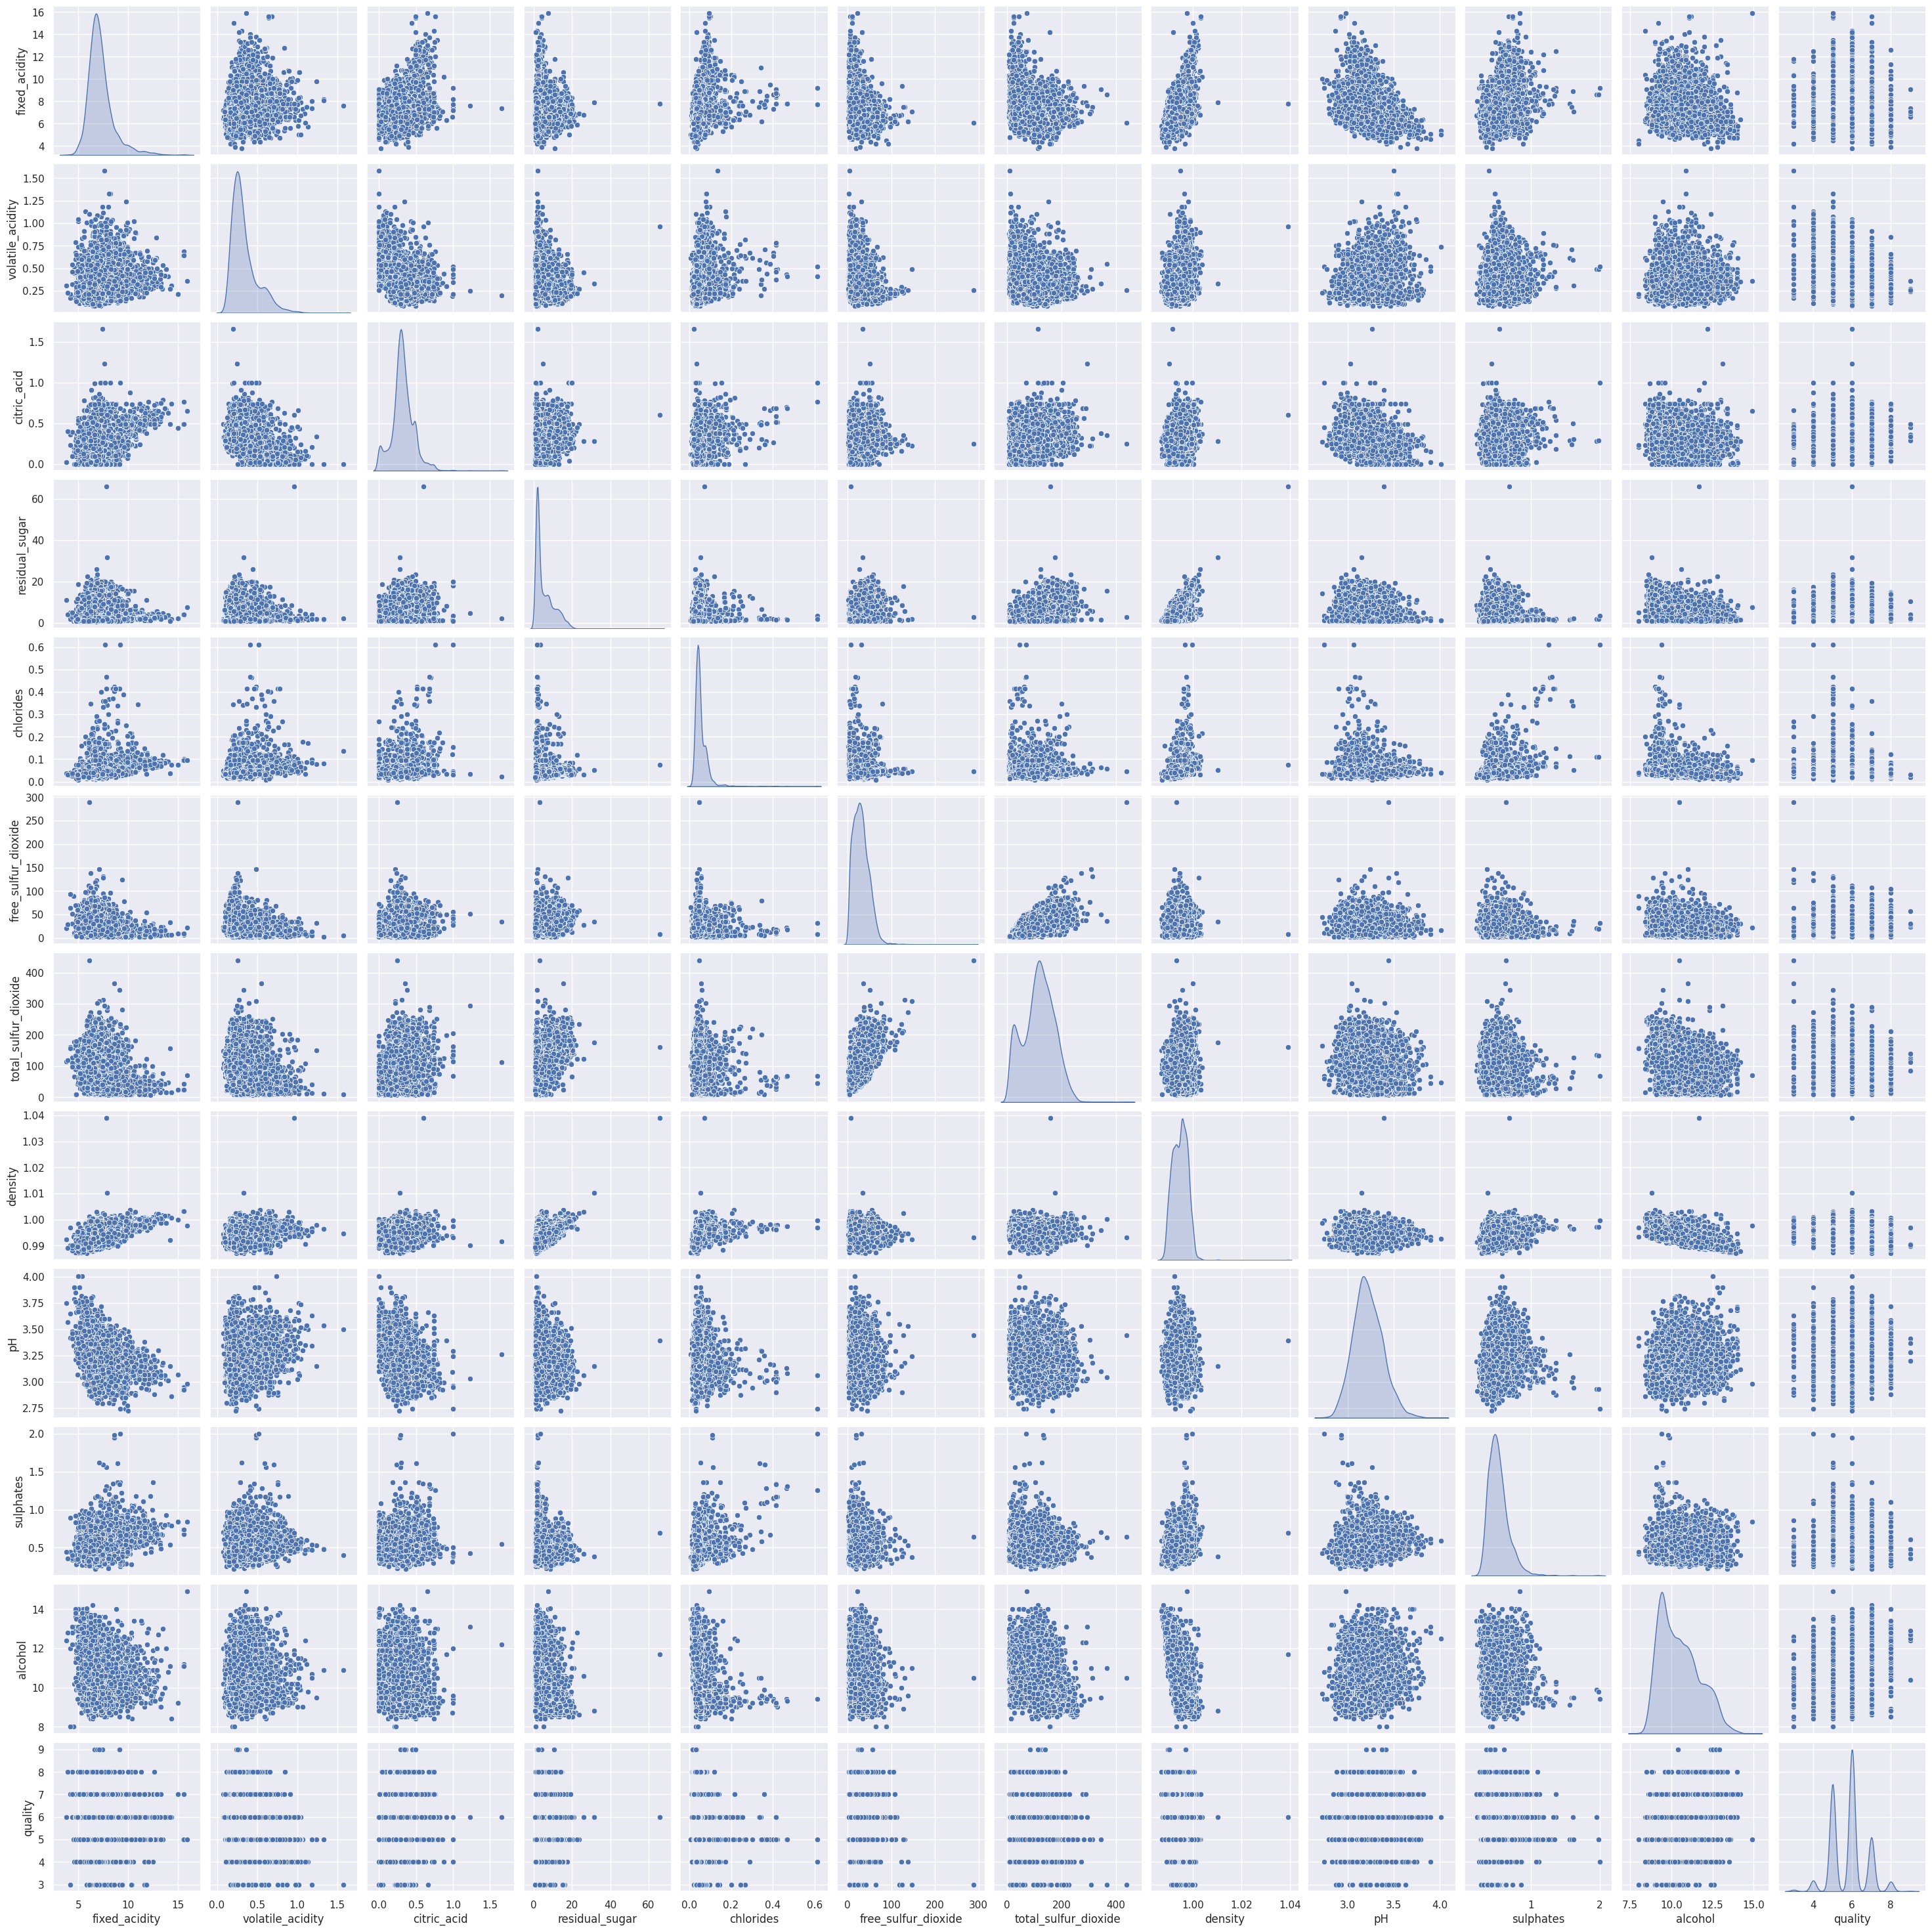

In [259]:
_ = sns.pairplot(df, diag_kind='kde')

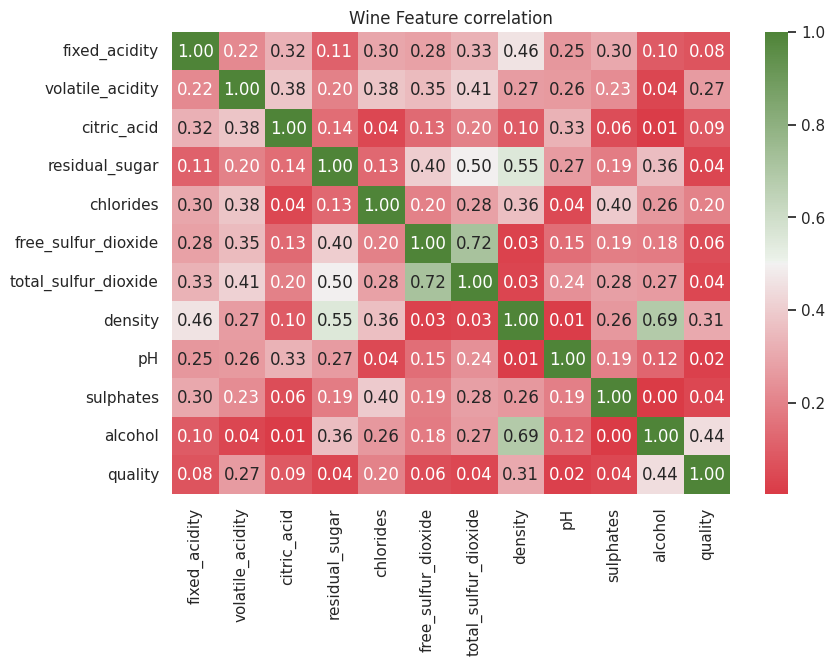

In [260]:
show_correlation_graph(df, title="Wine Feature correlation", cmap=None, linewidths=0, figsize=(9, 6), annot=True)

In [261]:
X = df.drop('color',axis= 1)
y = pd.DataFrame(X.pop("quality"))
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=101)


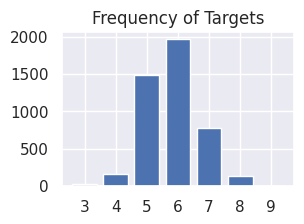

In [262]:
counts = []
for i in  y_train["quality"].unique():
    counts.append ( (i,   len(y_train[(y_train["quality"] == i)])) ) 
counts.sort(key=lambda x: x[0])
labels = [p[0] for p in counts]
values = [p[1] for p in counts]
plt.bar(labels, values)
plt.title("Frequency of Targets")
_ = plt.xticks(labels)

### Features distribution

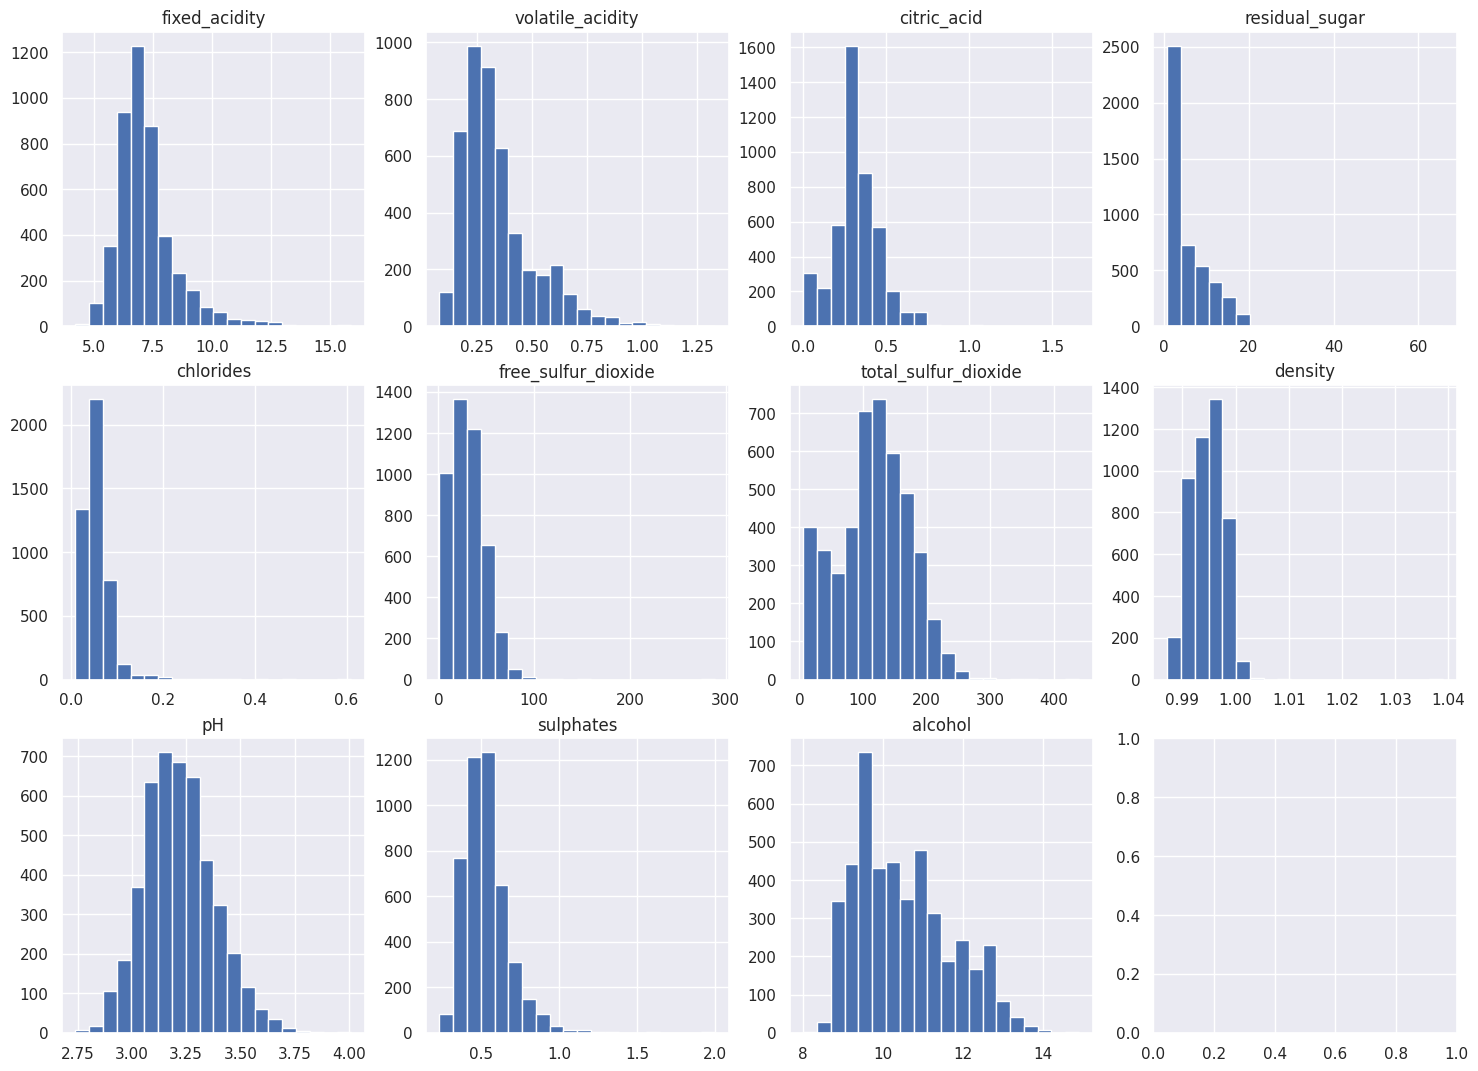

In [263]:
fig, x = plt.subplots(nrows=3, ncols=4, figsize = (18,13))
reshaped2 = np.reshape(x, (12, ))
for index, cn in enumerate(X_train.columns):
    reshaped2[index].hist(X_train[cn], bins=20)
    reshaped2[index].set_title(cn)
_= plt.show()



### Train the model 



In [264]:
model = LinearRegression().fit( X_train, y_train)

### Test the model using unseen data

In [265]:
predictions = model.predict(X_test)
print('mean_squared_error : ', mean_squared_error(y_test, predictions))
print('mean_absolute_error : ', mean_absolute_error(y_test, predictions))
dataset = pd.DataFrame({'Predicted': predictions.reshape((len(predictions),)), 'Expected': y_test["quality"]  })
dataset["MSE"] = (dataset["Expected"] - dataset["Predicted"]) ** 2
dataset

mean_squared_error :  0.5336721195885842
mean_absolute_error :  0.5653209053122744


,Predicted,Expected,MSE
868,6.024318,6,0.000591
5097,5.710654,6,0.083721
5450,6.943859,7,0.003152
5850,5.758772,6,0.058191
2192,5.306633,5,0.094024
...,...,...,...
6040,6.403890,6,0.163128
2890,5.736508,6,0.069428
914,6.189523,6,0.035919
1403,6.073486,8,3.711456
